## Redes Convolucionales
#### Ejemplo clasificación de perros y gatos para CAPTCHA

Este notebook utiliza datos de la [competición de Kaggle Dogs vs. Cats](https://www.kaggle.com/c/dogs-vs-cats/overview). En esta competicion se utiliza Asirra (Animal Species Image Recognition for Restricting Access), CAPTCHA que sirve para diferenciar entre una persona o una máquina accediendo a una página web. Este tipo de "pruebas" se utilizan para evitar emails de spam, y ataques por fuerza bruta contra servidores.

En este notebook vamos a probar que hay técnicas de clasificado automáticas de imágenes mediante redes neuronales, que con las que se intenta saltar CAPTCHA

# Import Library

In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
from keras.preprocessing.image import ImageDataGenerator, load_img
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import random
import os

# Define Constants
Tendremos una serie de constantes como las dimensiones de las imágenes, que serán fijas a lo largo de todo el notebook

In [2]:
IMAGE_WIDTH=32
IMAGE_HEIGHT=32
IMAGE_CHANNELS=3
IMAGE_SIZE=(IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_CHANNELS)
BATCH_SIZE = 10
EPOCHS = 5
ROOT_PATH = "cats_dogs/"

TRAIN_PATH_TOT = ROOT_PATH + "train\\train\\"
TEST_PATH_TOT = ROOT_PATH + "test\\test\\"

MINI_TRAIN_PATH = ROOT_PATH + "mini_train\\train\\"
MINI_TEST_PATH = ROOT_PATH + "mini_test\\test1\\"

TRAIN_PATH = TRAIN_PATH_TOT
TEST_PATH = TEST_PATH_TOT



#########

TRAIN_PATH = "cats_dogs_img/train/train/"
TEST_PATH = "cats_dogs_img/test1/test1/"

# Prepare Training Data
1. Descárgate el dataset de train de [la competición de Kaggle](https://www.kaggle.com/c/dogs-vs-cats/overview).
2. Descomprime el dataset y guardalo en la ruta que quieras del ordenador. Por supuesto, NO en la carpeta donde esté el repositorio
3. En este punto vamos guardar en una lista las etiquetas de cada foto.

In [3]:
filenames = os.listdir(TRAIN_PATH)

categories = []
for filename in filenames:
    category = filename.split('.')[0]
    if category == 'dog':
        categories.append(1)
    else:
        categories.append(0)

df = pd.DataFrame({
    'filename': filenames,
    'category': categories
})

In [4]:
df

,filename,category
0,cat.0.jpg,0
1,cat.1.jpg,0
2,cat.10.jpg,0
3,cat.100.jpg,0
4,cat.1000.jpg,0
...,...,...
24995,dog.9995.jpg,1
24996,dog.9996.jpg,1
24997,dog.9997.jpg,1
24998,dog.9998.jpg,1


### See Total In count

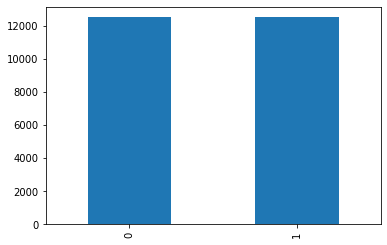

In [5]:
df['category'].value_counts().plot.bar();

# See sample image

(374, 500, 3)
255


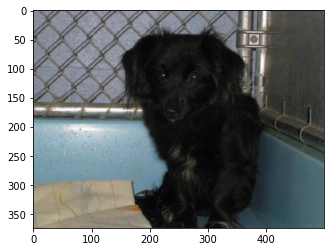

In [6]:
from skimage.io import imread
import cv2
#pip install opencv-python

sample = random.choice(filenames)
image = imread(TRAIN_PATH + sample)

print(image.shape)
print(np.max(image))
plt.imshow(image)

Una imagen no es mas que un array de HxWxC píxeles, siendo H(Height) y W(Width) las dimensiones de resolución de la imagen, y C el número de canales. Habrá tres valores por píxel. 

In [7]:
image

array([[[114, 117, 122],
        [124, 127, 134],
        [133, 136, 145],
        ...,
        [ 82,  81,  77],
        [ 89,  88,  84],
        [ 93,  92,  88]],

       [[125, 128, 133],
        [130, 133, 140],
        [132, 135, 144],
        ...,
        [ 83,  82,  78],
        [ 90,  89,  85],
        [ 95,  94,  90]],

       [[137, 140, 147],
        [137, 140, 147],
        [133, 136, 145],
        ...,
        [ 85,  84,  80],
        [ 91,  90,  86],
        [ 95,  94,  90]],

       ...,

       [[157, 150, 124],
        [155, 148, 122],
        [160, 152, 129],
        ...,
        [ 78, 111, 118],
        [ 78, 111, 118],
        [ 78, 111, 118]],

       [[151, 144, 116],
        [150, 143, 117],
        [155, 148, 122],
        ...,
        [ 78, 111, 118],
        [ 78, 111, 118],
        [ 78, 111, 118]],

       [[143, 136, 108],
        [141, 134, 106],
        [146, 139, 113],
        ...,
        [ 78, 111, 118],
        [ 78, 111, 118],
        [ 78, 111, 118]]

# Resize image
Cargar todas las imágenes a la vez es un problema ya que son un total de 25000 (unos 500MB la carpeta de train). Este proceso require mucha memoria, por lo que tendremos que aplicarle un resize a cada imagen para bajarlas de resolución. Esto también nos sirve para solventar el problema de tener imágenes con distintas resoluciones.

Tamaño imagen original: (375, 499, 3)
Tamaño imagen reshape: (32, 32, 3)
Maximo valor por pixel: 233


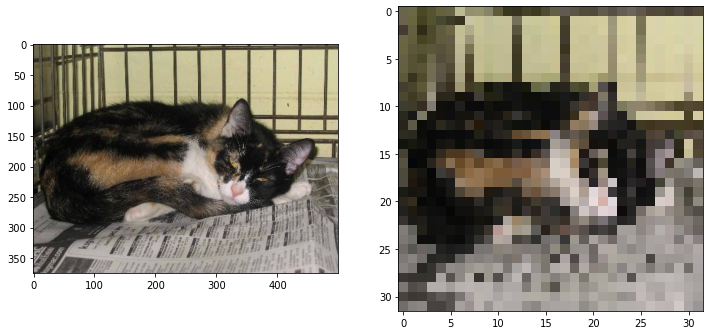

In [8]:
plt.figure(figsize=(12, 12))

sample = random.choice(filenames)
image = imread(TRAIN_PATH + sample)
imagesmall = cv2.resize(image, (IMAGE_WIDTH, IMAGE_HEIGHT))

print("Tamaño imagen original:", image.shape)
print("Tamaño imagen reshape:", imagesmall.shape)
print("Maximo valor por pixel:", np.max(imagesmall))

# Original image
plt.subplot(1, 2, 1)
plt.imshow(image)

# Resized image
plt.subplot(1, 2, 2)
plt.imshow(imagesmall);

# Color
Podríamos cargar las imágenes como blanco y negro, de esta forma se reduciría el espacio de features considerablemente al contar con un único canal

Dimensiones: (313, 300)
Maximo color: 255


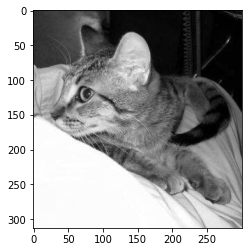

In [9]:
sample = random.choice(filenames)

image = cv2.imread(filename=TRAIN_PATH+sample, flags=cv2.IMREAD_GRAYSCALE)

print("Dimensiones:", image.shape)
print("Maximo color:", np.max(image))
plt.imshow(image, cmap='gray');

# Load data
Llega el momento de cargar los datos. Ya no estan sencillo como cuando teníamos datasets en CSVs puesto que ahora hay que cargar miles de archivos en memoria en este notebook. Para ello necesitaremos un programa iterativo que vaya recorriendo los archivos de la carpeta, cargarlos como array de numpy y almacenarlos en un objeto.

In [10]:
np.random.choice(os.listdir(TRAIN_PATH), size=10)

array(['cat.3978.jpg', 'dog.5261.jpg', 'cat.4237.jpg', 'cat.9647.jpg',
       'dog.8689.jpg', 'cat.5067.jpg', 'cat.11219.jpg', 'cat.2960.jpg',
       'dog.7267.jpg', 'dog.231.jpg'], dtype='<U13')

In [11]:
def read_data(path, im_size, sample_size):
    X = []
    Y = []

    pics = np.random.choice(os.listdir(path), size=sample_size)

    for file in pics:
        image = imread(path + "/" + file)
        smallimage = cv2.resize(image, (IMAGE_WIDTH, IMAGE_HEIGHT))

        X.append(smallimage)

        category = file.split('.')[0]
        if category == "dog":
            Y.append(1)
        else:
            Y.append(0)

    return np.array(X), np.array(Y)
    

X_train, y_train = read_data(TRAIN_PATH, IMAGE_SIZE, 5000)
X_test, y_test = read_data(TEST_PATH, IMAGE_SIZE, 500)

print(X_train.shape)
print(X_test.shape)

(5000, 32, 32, 3)
(500, 32, 32, 3)


(32, 32, 3)


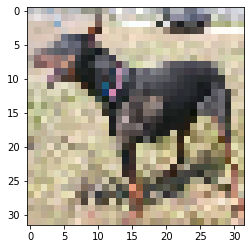

In [12]:
print(X_train[0].shape)
plt.imshow(X_train[0]);

In [13]:
X_train[0]

array([[[183, 186, 191],
        [207, 207, 208],
        [187, 187, 189],
        ...,
        [193, 192, 203],
        [210, 213, 222],
        [217, 219, 227]],

       [[220, 213, 210],
        [233, 227, 228],
        [218, 212, 213],
        ...,
        [180, 180, 180],
        [213, 212, 217],
        [192, 190, 194]],

       [[209, 198, 180],
        [214, 195, 181],
        [213, 194, 181],
        ...,
        [162, 169, 116],
        [206, 207, 175],
        [188, 191, 146]],

       ...,

       [[177, 162, 133],
        [192, 178, 149],
        [183, 168, 145],
        ...,
        [224, 196, 167],
        [114,  85,  69],
        [144,  90,  70]],

       [[201, 186, 156],
        [200, 183, 148],
        [189, 170, 144],
        ...,
        [209, 205, 151],
        [149, 120,  97],
        [230, 183, 152]],

       [[207, 184, 159],
        [200, 184, 158],
        [202, 187, 157],
        ...,
        [182, 170, 135],
        [242, 209, 189],
        [200, 167, 150]]

# Normalized data
Normalizar los datos hará que entrene mucho mejor la red, al estar todos los pixeles en la misma escala.

In [14]:
print("Min:", np.min(X_train))
print("Max:", np.max(X_train))

Min: 0
Max: 255


In [15]:
X_train = X_train / 255.0
X_test = X_test / 255.0

print("Min:", np.min(X_train))
print("Max:", np.max(X_train))

Min: 0.0
Max: 1.0


# Shuffle data
Como hemos cargado los datos de manera ordenada (primero gatos y luego perros), tendremos que desordenarlos para asegurarnos de que no haya ningún sesgo en el entrenamiento ni en la selección de datos de validación.

In [16]:
from sklearn.utils import shuffle
X_train, y_train = shuffle(X_train, y_train, random_state = 42)

# Save data
Podemos guardar los arrays de numpy en un archivo `.npz`, de tal manera que luego sea más rápido importarlo

In [17]:
np.savez("data.npz", X_train = X_train, y_train = y_train, X_test = X_test, y_test = y_test)

Para cargar

In [18]:
data = np.load("data.npz")

X_train = data['X_train']
X_test = data['X_test']
y_train = data['y_train']
y_test = data['y_test']

# Build Model

<img src="https://i.imgur.com/ebkMGGu.jpg" width="100%"/>

* **Conv Layer**: extraerá diferentes features de las imagenes
* **Pooling Layer**: Reduce las dimensiones de las imágenes tras una capa convolucional
* **Fully Connected Layer**: Tras las capas convolucionales, aplanamos las features y las introducimos como entrada de una red neuronal normal.
* **Output Layer**: Las predicciones de la red

Para el loss y la metrica, se puede usar un binary_crossentropy, al ser un target binario. O 

In [19]:
from tensorflow import keras

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Activation

model = Sequential()

model.add(Conv2D(32, (3,3), activation='relu',
input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_CHANNELS)))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, (3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

"""
También podríamos haber usado dos neuronas de salida, para ello
hay que pasar la y a one-hot-encoding
from keras.utils import to_categorical
y_train = to_categorical(y_train)
model.add(Dense(2, activation='softmax')) y categorica
Si tuviera 23 o más clases tendría que usar esta opción

"""

model.compile(optimizer="adam",
loss='binary_crossentropy',
metrics = ['accuracy'])





In [20]:
keras.__version__

'2.8.0'

In [21]:
y_train

array([1, 0, 0, ..., 1, 1, 1])

In [21]:
history = model.fit(X_train,
y_train,
epochs = 10,
batch_size=4000,
validation_split=0.2)

Epoch 1/10
1/1 [==============================] - 25s 25s/step - loss: 0.6993 - accuracy: 0.4893 - val_loss: 0.6984 - val_accuracy: 0.5130
Epoch 2/10
1/1 [==============================] - 14s 14s/step - loss: 0.7288 - accuracy: 0.4920 - val_loss: 0.6927 - val_accuracy: 0.5320
Epoch 3/10
1/1 [==============================] - 13s 13s/step - loss: 0.6936 - accuracy: 0.5120 - val_loss: 0.6939 - val_accuracy: 0.4870
Epoch 4/10
1/1 [==============================] - 14s 14s/step - loss: 0.6957 - accuracy: 0.5105 - val_loss: 0.6941 - val_accuracy: 0.4870
Epoch 5/10
1/1 [==============================] - 12s 12s/step - loss: 0.6970 - accuracy: 0.5058 - val_loss: 0.6936 - val_accuracy: 0.4870
Epoch 6/10
1/1 [==============================] - 18s 18s/step - loss: 0.6948 - accuracy: 0.5065 - val_loss: 0.6932 - val_accuracy: 0.4870
Epoch 7/10
1/1 [==============================] - 13s 13s/step - loss: 0.6931 - accuracy: 0.5035 - val_loss: 0.6930 - val_accuracy: 0.4880
Epoch 8/10
1/1 [===========

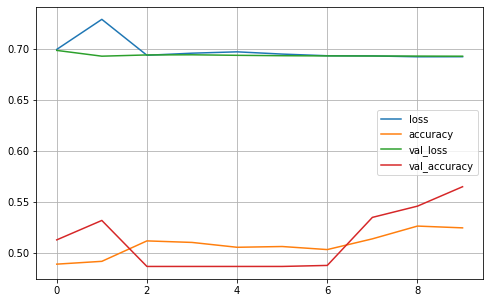

In [22]:
pd.DataFrame(history.history).plot(figsize=(8,5))
plt.grid(True)

In [23]:
# Evaluar
results = model.evaluate(X_test, y_test)
print("test loss, test accuracy", results)

16/16 [==============================] - 1s 29ms/step - loss: 0.6909 - accuracy: 0.7820
test loss, test accuracy [0.6909468770027161, 0.7820000052452087]


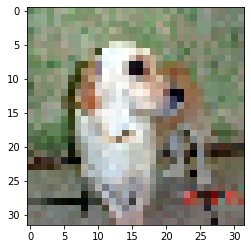

In [24]:
plt.imshow(X_test[0])

In [25]:
model.predict(X_test[0])

ValueError: in user code:

    File "C:\Users\Admin\AppData\Local\Programs\Python\Python37\lib\site-packages\keras\engine\training.py", line 1801, in predict_function  *
        return step_function(self, iterator)
    File "C:\Users\Admin\AppData\Local\Programs\Python\Python37\lib\site-packages\keras\engine\training.py", line 1790, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\Admin\AppData\Local\Programs\Python\Python37\lib\site-packages\keras\engine\training.py", line 1783, in run_step  **
        outputs = model.predict_step(data)
    File "C:\Users\Admin\AppData\Local\Programs\Python\Python37\lib\site-packages\keras\engine\training.py", line 1751, in predict_step
        return self(x, training=False)
    File "C:\Users\Admin\AppData\Local\Programs\Python\Python37\lib\site-packages\keras\utils\traceback_utils.py", line 67, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "C:\Users\Admin\AppData\Local\Programs\Python\Python37\lib\site-packages\keras\engine\input_spec.py", line 264, in assert_input_compatibility
        raise ValueError(f'Input {input_index} of layer "{layer_name}" is '

    ValueError: Input 0 of layer "sequential" is incompatible with the layer: expected shape=(None, 32, 32, 3), found shape=(32, 32, 3)


In [26]:
X_test[0].shape

(32, 32, 3)

In [27]:
np.expand_dims(X_test[0], axis=0).shape

(1, 32, 32, 3)

In [28]:
model.predict(np.expand_dims(X_test[0], axis=0))

array([[0.4978962]], dtype=float32)

In [29]:
# image data generator

df["category"] = df["category"].replace({0: 'cat', 1: 'dog'})

print("Categorias:", df['category'].unique())
df.head()

Categorias: ['cat' 'dog']


,filename,category
0,cat.0.jpg,cat
1,cat.1.jpg,cat
2,cat.10.jpg,cat
3,cat.100.jpg,cat
4,cat.1000.jpg,cat


In [30]:
example_df = df.sample(n=1).reset_index(drop=True)

train_datagen = ImageDataGenerator(
    rotation_range=15,
    rescale=1./255,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1
)

example_generator = train_datagen.flow_from_dataframe(
    example_df, 
    TRAIN_PATH, 
    x_col='filename',
    y_col='category',
    target_size=(IMAGE_HEIGHT, IMAGE_WIDTH),
)

Found 1 validated image filenames belonging to 1 classes.


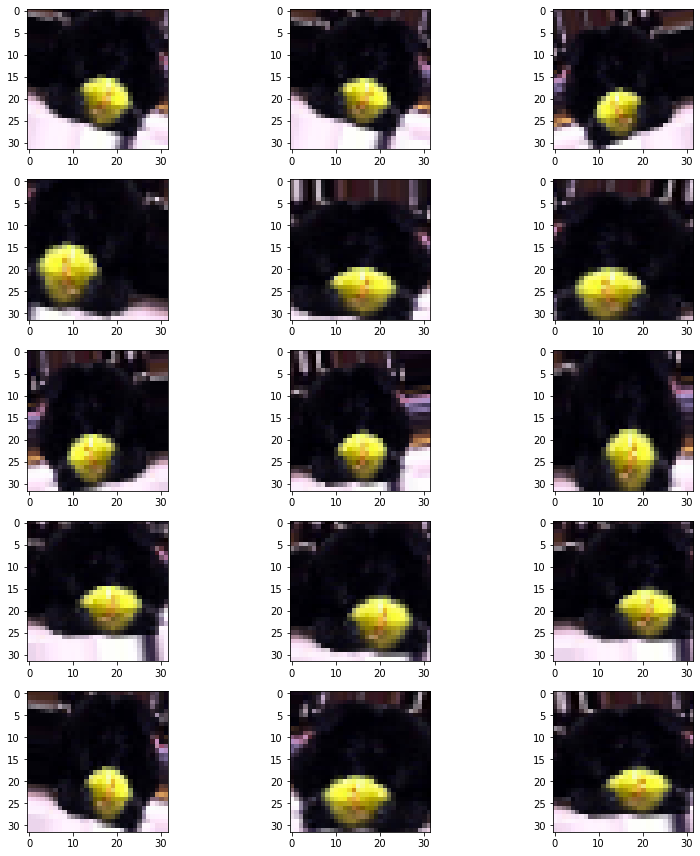

In [31]:
plt.figure(figsize=(12, 12))

for i in range(0, 15):
    plt.subplot(5, 3, i+1)
    for X_batch, Y_batch in example_generator:
        image = X_batch[0]
        plt.imshow(image)
        break
plt.tight_layout()
plt.show()

In [32]:
train_df, validate_df = train_test_split(df.sample(5500),
                                         test_size=500,
                                         random_state=42)

train_df = train_df.reset_index(drop=True)
validate_df = validate_df.reset_index(drop=True)

In [33]:
total_train = train_df.shape[0]
total_validate = validate_df.shape[0]

print("Shape train", total_train)
print("Shape validation", total_validate)
validate_df.head()

Shape train 5000
Shape validation 500


,filename,category
0,dog.11009.jpg,dog
1,dog.1502.jpg,dog
2,dog.5654.jpg,dog
3,cat.2833.jpg,cat
4,cat.7829.jpg,cat


In [34]:
train_df.head()

,filename,category
0,dog.11098.jpg,dog
1,cat.4513.jpg,cat
2,cat.4753.jpg,cat
3,dog.7391.jpg,dog
4,dog.5712.jpg,dog


In [35]:
train_df.category.value_counts()

dog    2532
cat    2468
Name: category, dtype: int64

In [36]:
train_datagen = ImageDataGenerator(
    rotation_range=15,
    rescale=1./255,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1
)

train_generator = train_datagen.flow_from_dataframe(
    train_df, 
    TRAIN_PATH, 
    x_col='filename',
    y_col='category',
    target_size=(IMAGE_HEIGHT, IMAGE_WIDTH),
    class_mode='binary',
    batch_size=BATCH_SIZE
)

Found 5000 validated image filenames belonging to 2 classes.


In [37]:
validation_datagen = ImageDataGenerator(rescale=1./255)
validation_generator = validation_datagen.flow_from_dataframe(
    train_df, 
    TRAIN_PATH, 
    x_col='filename',
    y_col='category',
    target_size=(IMAGE_HEIGHT, IMAGE_WIDTH),
    class_mode='binary',
    batch_size=BATCH_SIZE
)

Found 5000 validated image filenames belonging to 2 classes.


In [40]:
history = model.fit(
    train_generator, 
    epochs=EPOCHS,
    validation_data=validation_generator
)

Epoch 1/5
500/500 [==============================] - 76s 152ms/step - loss: 0.6370 - accuracy: 0.6326 - val_loss: 0.6005 - val_accuracy: 0.6800
Epoch 2/5
270/500 [===============>..............] - ETA: 22s - loss: 0.6296 - accuracy: 0.6370

KeyboardInterrupt: 

In [39]:
results = model.evaluate(X_test, y_test)
print("test loss, test acc:", results)

16/16 [==============================] - 1s 30ms/step - loss: 0.7862 - accuracy: 0.4900
test loss, test acc: [0.7861993908882141, 0.49000000953674316]


In [ ]:
model.save_weights("model.h5")

# Callbacks
#### Early Stopping

In [22]:
from keras.callbacks import EarlyStopping
earlystop = EarlyStopping(patience=10)

# Fit the model

In [23]:
history = model.fit(X_train, y_train,
        epochs = EPOCHS,
        batch_size = BATCH_SIZE,
        validation_split = 0.2)

Epoch 1/5
400/400 [==============================] - 44s 90ms/step - loss: 0.6930 - accuracy: 0.5290 - val_loss: 0.6925 - val_accuracy: 0.4880
Epoch 2/5
400/400 [==============================] - 43s 107ms/step - loss: 0.6896 - accuracy: 0.5295 - val_loss: 0.6832 - val_accuracy: 0.5430
Epoch 3/5
400/400 [==============================] - 35s 87ms/step - loss: 0.6858 - accuracy: 0.5558 - val_loss: 0.6841 - val_accuracy: 0.5460
Epoch 4/5
400/400 [==============================] - 31s 77ms/step - loss: 0.6648 - accuracy: 0.5960 - val_loss: 0.6807 - val_accuracy: 0.5420
Epoch 5/5
400/400 [==============================] - 22s 56ms/step - loss: 0.6461 - accuracy: 0.6317 - val_loss: 0.6365 - val_accuracy: 0.6600


# Evaluate
Probemos los datos en el conjunto de test.

In [ ]:
##### CODE #####

In [ ]:
plt.imshow(X_test[0]);

In [ ]:
##### CODE #####

# Image data generator

In [ ]:
df["category"] = df["category"].replace({0: 'cat', 1: 'dog'})

print("Categorias:", df['category'].unique())
df.head()

In [ ]:
##### CODE #####

In [ ]:
plt.figure(figsize=(12, 12))

for i in range(0, 15):
    plt.subplot(5, 3, i+1)
    for X_batch, Y_batch in example_generator:
        image = X_batch[0]
        plt.imshow(image)
        break
plt.tight_layout()
plt.show()

In [ ]:
train_df, validate_df = train_test_split(df,
                                         test_size=0.20,
                                         random_state=42)

train_df = train_df.reset_index(drop=True)
validate_df = validate_df.reset_index(drop=True)

In [ ]:
total_train = train_df.shape[0]
total_validate = validate_df.shape[0]

print("Shape train", total_train)
print("Shape validation", total_validate)
validate_df.head()

In [ ]:
train_df.head()

# Training Generator

In [ ]:
train_generator = train_datagen.flow_from_dataframe(
    train_df, 
    TRAIN_PATH, 
    x_col='filename',
    y_col='category',
    target_size=(IMAGE_HEIGHT, IMAGE_WIDTH),
    class_mode='binary',
    batch_size=BATCH_SIZE
)

### Validation Generator

In [ ]:
validation_datagen = ImageDataGenerator(rescale=1./255)
validation_generator = validation_datagen.flow_from_dataframe(
    train_df, 
    TRAIN_PATH, 
    x_col='filename',
    y_col='category',
    target_size=(IMAGE_HEIGHT, IMAGE_WIDTH),
    class_mode='binary',
    batch_size=BATCH_SIZE
)

# Fit Model

In [ ]:
##### CODE #####

In [ ]:
##### CODE #####

In [ ]:
results = model.evaluate(X_test, y_test)
print("test loss, test acc:", results)

# Virtualize Training

In [ ]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))
ax1.plot(history.history['loss'], color='b', label="Training loss")
ax1.plot(history.history['val_loss'], color='r', label="validation loss")
ax1.set_xticks(np.arange(1, EPOCHS, 1))
ax1.set_yticks(np.arange(0, 1, 0.1))

ax2.plot(history.history['accuracy'], color='b', label="Training accuracy")
ax2.plot(history.history['val_accuracy'], color='r',label="Validation accuracy")
ax2.set_xticks(np.arange(1, EPOCHS, 1))

legend = plt.legend(loc='best', shadow=True)
plt.tight_layout()
plt.show()